In [1]:
import os

from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [10]:
#!pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [2]:
categories=['COVID19','NORMAL','PNEUMONIA']

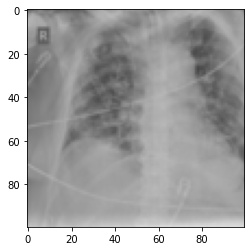

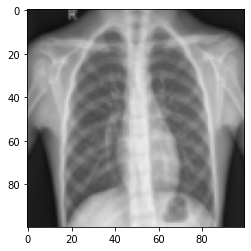

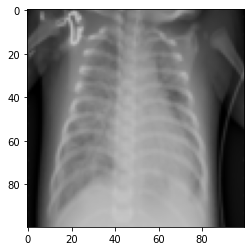

In [3]:
def get_image(filename, root):
    file_path = os.path.join(root, filename)
    img = np.array(Image.open(file_path))
    img_resized = resize(img,(100,100,3)) #resize to 150 x 150 because original have different sizes
    return img_resized
        
        
#cmap = "bone" if not will get this weird blue-ish green hue
#show the corresponding image of COVID19
plt.imshow(get_image("COVID19(0).jpg","Data/train/COVID19/"), cmap="bone")
plt.show()

#show the corresponding image of normal
plt.imshow(get_image("NORMAL(0).jpg","Data/train/NORMAL/"), cmap="bone")
plt.show()

#show the corresponding image of pneumonia
plt.imshow(get_image("PNEUMONIA(0).jpg","Data/train/PNEUMONIA/"), cmap="bone")
plt.show()


In [4]:
#flatten 3d array to 1d array
#hog means histogram of oriented gradients
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

In [5]:
def create_feature_matrix(root,categories):
    features_list = []
    label_arr = []
    for i in categories:
        print(f'loading... category : {i}')
        path = os.path.join(root,i)
        for filename in tqdm(os.listdir(path)):
            img = get_image(filename, path)
            image_features = create_features(img)
            features_list.append(image_features)
            label_arr.append(categories.index(i))
            
    feature_matrix = np.array(features_list)
    labels=np.array(label_arr)
    
    return feature_matrix, labels

In [6]:
# run create_feature_matrix on our dataframe of images (train)
#0:covid19
#1:normal
#2:pneumonia
feature_matrix, labels = create_feature_matrix("Data/train/",categories)

loading... category : COVID19


  0%|          | 0/460 [00:00<?, ?it/s]

loading... category : NORMAL


  0%|          | 0/1266 [00:00<?, ?it/s]

loading... category : PNEUMONIA


  0%|          | 0/3418 [00:00<?, ?it/s]

In [7]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define Min Max scaler
mms = MinMaxScaler()
mmscaler = mms.fit(feature_matrix)
xray_stand = mmscaler.transform(feature_matrix)

Feature matrix shape is:  (5144, 30000)


In [8]:
X = pd.DataFrame(xray_stand)
y = pd.Series(labels)

#count current number of x and y 
#y.count()
y.value_counts()

2    3418
1    1266
0     460
dtype: int64

In [11]:
#undersampling to bring down num of normal and pneumonia samples
#from imblearn.under_sampling import RandomUnderSampler

#X = pd.DataFrame(xray_stand)
#y = pd.Series(labels)
#count current number of x and y 
#y.count()
#y.value_counts()

#undersampling to bring down num of normal and pneumonia samples
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

In [12]:
#0:covid19
#1:normal
#2:pneumonia
y.value_counts()

0    460
1    460
2    460
dtype: int64

In [13]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

In [14]:
#search for best SVC model (nadya's code)
#only run the first time to get best parameters. Don't need to run again.
from sklearn.model_selection import GridSearchCV

param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=SVC(probability=True)

model=GridSearchCV(svc,param_grid)
model.fit(X_train,y_train)

model.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [15]:
# define support vector classifier
svm = SVC(kernel='rbf', probability=True, C = 10, gamma = 0.001, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.001, probability=True, random_state=42)

In [16]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.9541062801932367


In [17]:
# predict probabilities for X_test using predict_proba
y_score = svm.predict_proba(X_test)

for i,cat in enumerate(categories):
  print(f'{cat} = {y_score[0][i]*100}%')

COVID19 = 0.070174595614593%
NORMAL = 0.4381157706151413%
PNEUMONIA = 99.49170963377026%


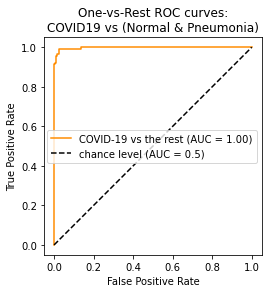

In [18]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

RocCurveDisplay.from_predictions(
    y_onehot_test[:, 0],
    y_score[:, 0],
    name= "COVID-19 vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nCOVID19 vs (Normal & Pneumonia)")
plt.legend()
plt.show()

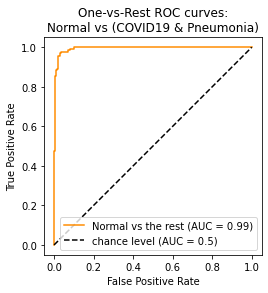

In [19]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 1],
    y_score[:, 1],
    name= "Normal vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNormal vs (COVID19 & Pneumonia)")
plt.legend()
plt.show()

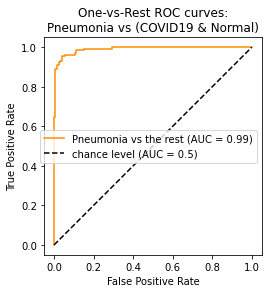

In [20]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 2],
    y_score[:, 2],
    name= "Pneumonia vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nPneumonia vs (COVID19 & Normal)")
plt.legend()
plt.show()

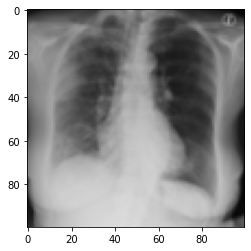

Prediction is: [0]
COVID19 = 99.54551218517575%
NORMAL = 0.3563451108383907%
PNEUMONIA = 0.09814270398585284%


In [26]:
#test for covid19 image
testImg1 = get_image("COVID19(472).jpg","Data/test/COVID19/")
test_features1 = create_features(testImg1)
test_matrix = np.array([test_features1]).reshape(1,-1)

plt.imshow(testImg1)
plt.show()

test_stand1 = mmscaler.transform(test_matrix)

print('Prediction is:', svm.predict(test_stand1))

covid_score = svm.predict_proba(test_stand1)

for i,cat in enumerate(categories):
  print(f'{cat} = {covid_score[0][i]*100}%')

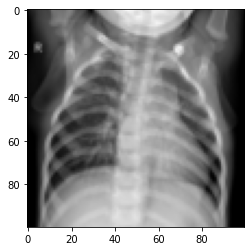

Prediction is: [1]
COVID19 = 0.018429105369797867%
NORMAL = 98.46895704981283%
PNEUMONIA = 1.5126138448173554%


In [27]:
#test for normal image
testImg2 = get_image("NORMAL(1268).jpg","Data/test/NORMAL")
test_features2 = create_features(testImg2)
test_matrix2 = np.array([test_features2]).reshape(1,-1)

plt.imshow(testImg2)
plt.show()

test_stand2 = mmscaler.transform(test_matrix2)

print('Prediction is:', svm.predict(test_stand2))

normal_score = svm.predict_proba(test_stand2)

for i,cat in enumerate(categories):
  print(f'{cat} = {normal_score[0][i]*100}%')

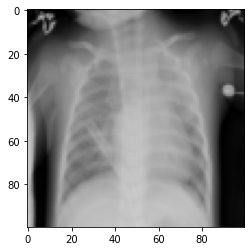

prediction is: [2]
COVID19 = 12.4091283000991%
NORMAL = 7.872428530042269%
PNEUMONIA = 79.71844316985862%


In [29]:
#load pneumonia image
testImg3 = get_image("PNEUMONIA(3432).jpg","Data/test/PNEUMONIA")
test_features3 = create_features(testImg3)
test_matrix3 = np.array([test_features3]).reshape(1,-1)

plt.imshow(testImg3)
plt.show()

test_stand3 = mmscaler.transform(test_matrix3)

print('prediction is:', svm.predict(test_stand3))

pneumonia_score = svm.predict_proba(test_stand3)

for i,cat in enumerate(categories):
  print(f'{cat} = {pneumonia_score[0][i]*100}%')

In [30]:
from joblib import dump

In [31]:
dump(svm, 'svmModel_2.joblib')

['svmModel_2.joblib']

In [32]:
dump(mmscaler,'mmscaler.joblib')

['mmscaler.joblib']